# Textual Analysis of Company Business Models to Explain Varying Exposures to Covid-19 Market Shock

Author: Adil Wahab, Aparna Raman, Di Yao, Missy Putur, Luke Towers <br>
Date : April 19,2020

## Data Preparation
**Please see the colab notebook BA870_group_project_scraping.ipynb on scrapping the company's description from Yahoo finance. We started this notebook by loading the exported file "stock_dec.csv"**

In [ ]:
from google.colab import files
import numpy as np
import pandas as pd
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
import torch
import warnings

!pip install transformers

import transformers as ppb

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


     |████████████████████████████████| 573kB 2.6MB/s 
     |████████████████████████████████| 890kB 12.5MB/s 
     |████████████████████████████████| 3.7MB 11.6MB/s 
     |████████████████████████████████| 1.0MB 35.7MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.41-cp36-none-any.whl size=893334 sha256=f29618aa619486f07151b3affbfeff595fab8a1c44ad1e18ae39765229561cb4
  Stored in directory: /root/.cache/pip/wheels/22/5a/d4/b020a81249de7dc63758a34222feaa668dbe8ebfe9170cc9b1
Successfully built sacremoses


In [ ]:
uploaded = files.upload()

Saving stock_des.csv to stock_des.csv


In [ ]:
dfDescriptions = pd.read_csv('stock_des.csv')

In [ ]:
uploaded = files.upload()

Saving BA870 Project Data 2020.xlsx to BA870 Project Data 2020.xlsx


In [ ]:
df = pd.read_excel('BA870 Project Data 2020.xlsx')

We divided the data into two buckets based on their returns for the past 3 months since COVID-19 began to heavily impact businesses globally.

**The buckets are as follows:**


*   **Bucket 1:** This bucket contains the ~top 20% of companies that have had the best returns over the last 3 months. The returns for these companies was greater than or equal to -15%
*   **Bucket 2:** This bucket contains the ~bottom 80% of companies in terms of returns over the last 3 months. The returns for these companies was less than -15%. 

In [ ]:
print(df.loc[df["3-mth Ret"] >= -.15, '3-mth Ret'].count())
print(df.loc[df["3-mth Ret"] >= -.15, '3-mth Ret'].count()/ df.shape[0])

263
0.19324026451138868


Creating the buckets based on the greater than/less than -15% threshold described above.

In [ ]:
df["3_month_bucket"] = df["3-mth Ret"].apply(lambda x: 0 if x < -.15 else 1)

With the breakdown, 1098 companies are in the "Bottom 80%" bucket and 263 companies are in the "Top 20%" bucket.

In [ ]:
df["3_month_bucket"].groupby(df["3_month_bucket"]).count()

3_month_bucket
0    1098
1     263
Name: 3_month_bucket, dtype: int64

Spot checking the data, we see that a couple of pharmaceutical or lab-based companies, as well as Zoom, are categorized in the "Top 20%" group as expected.

In [ ]:
df.loc[df['3_month_bucket'] == 1]

,tic,conm_x,Last Price,YTD Ret,1-mth Ret,3-mth Ret,12-mth Ret,BothSP-NASDAQ,SP500,Ticker,gvkey,datadate,fyear,cusip,conm_y,fyr,exchg,cik,fic,addzip,city,gsubind,naics,sic,state,PERMNO,date,NCUSIP,COMNAM,PERMCO,CUSIP,3_month_bucket
2,AAON,Aaon Inc,44.91,-0.0911,-0.2006,-0.1080,-0.0194,0,0,AAON,21542.0,20191231.0,2019.0,360206,AAON INC,12.0,14.0,824142.0,USA,74107,Tulsa,20102010.0,333415.0,3585.0,OK,76868.0,20191231.0,36020,AAON INC,10817.0,36020,1
8,ABC,Amerisourcebergen Corp,81.34,-0.0433,-0.0528,-0.0318,0.0838,0,1,ABC,31673.0,20190930.0,2019.0,3.07E+108,AMERISOURCEBERGEN CORP,9.0,11.0,1140859.0,USA,19087,Chesterbrook,35102010.0,424210.0,5122.0,PA,81540.0,20191231.0,3.07E+13,AMERISOURCEBERGEN CORP,13650.0,3.07E+13,1
11,ABT,Abbott Laboratories,79.45,-0.0853,0.0187,-0.0750,-0.0006,0,1,ABT,1078.0,20191231.0,2019.0,2824100,ABBOTT LABORATORIES,12.0,11.0,1800.0,USA,60064,Abbott Park,35101010.0,334510.0,3845.0,IL,20482.0,20191231.0,282410,ABBOTT LABORATORIES,20017.0,282410,1
13,ACAD,Acadia Pharmaceutica,40.76,-0.0472,-0.0291,0.0102,0.4903,0,0,ACAD,141846.0,20191231.0,2019.0,4225108,ACADIA PHARMACEUTICALS INC,12.0,14.0,1070494.0,USA,92130,San Diego,35201010.0,325414.0,2836.0,CA,90177.0,20191231.0,422510,ACADIA PHARMACEUTICALS,45190.0,422510,1
16,ACIA,Acacia Communica,66.40,-0.0208,-0.0304,-0.0250,0.1239,0,0,ACIA,26722.0,20191231.0,2019.0,00401C108,ACACIA COMMUNICATIONS INC,12.0,14.0,1651235.0,USA,1754,Maynard,45201020.0,334220.0,3663.0,MA,16051.0,20191231.0,00401C10,ACACIA COMMUNICATIONS INC,55562.0,00401C10,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1356,ZLAB,Zai Lab Ltd,51.55,0.2395,-0.1126,0.3005,0.6841,0,0,ZLAB,32334.0,20191231.0,2019.0,98887Q104,ZAI LAB LIMITED -ADS,12.0,14.0,1704292.0,CYM,201210,Shanghai,35201010.0,325414.0,2836.0,NaN,16938.0,20191231.0,98887Q10,ZAI LAB LIMITED,56070.0,98887Q10,1
1357,ZM,Zoom Video Communications Cl A,128.20,0.8842,0.0913,0.9055,1.0677,0,0,ZM,35005.0,20190131.0,2018.0,98980L101,ZOOM VIDEO COMUNICATIONS INC,1.0,14.0,1585521.0,USA,95113,San Jose,45103010.0,519130.0,7370.0,CA,18484.0,20191231.0,98980L10,ZOOM VIDEO COMMUNICATIONS INC,56690.0,98980L10,1
1358,ZNGA,Zynga Inc Cl A,6.64,0.0850,-0.0349,0.0658,0.2183,0,0,ZNGA,187576.0,20191231.0,2019.0,98986T108,ZYNGA INC,12.0,14.0,1439404.0,USA,94103,San Francisco,50202020.0,511210.0,7372.0,CA,13169.0,20191231.0,98986T10,ZYNGA INC,53965.0,98986T10,1
1359,ZS,Zscaler Inc,63.40,0.3634,0.2351,0.3381,-0.0857,0,0,ZS,33037.0,20190731.0,2019.0,98980G102,ZSCALER INC,7.0,14.0,1713683.0,USA,95134,San Jose,45103020.0,519130.0,7370.0,CA,17341.0,20191231.0,98980G10,ZSCALER INC,56287.0,98980G10,1


Merge two dataset into one

In [ ]:
dfDescriptions = pd.merge(dfDescriptions,
                 df,
                 how = 'left',
                 left_on="ticker", right_on="tic")

In [ ]:
dfDescriptions.head()

,ticker,description,YTD,tic,conm_x,Last Price,YTD Ret,1-mth Ret,3-mth Ret,12-mth Ret,BothSP-NASDAQ,SP500,Ticker,gvkey,datadate,fyear,cusip,conm_y,fyr,exchg,cik,fic,addzip,city,gsubind,naics,sic,state,PERMNO,date,NCUSIP,COMNAM,PERMCO,CUSIP,3_month_bucket
0,A,"Agilent Technologies, Inc. provides applicatio...",-0.1745,A,Agilent Technologies,70.42,-0.1745,-0.1233,-0.1673,-0.1406,0,1,A,126554.0,20191031.0,2019.0,00846U101,AGILENT TECHNOLOGIES INC,10.0,11.0,1090872.0,USA,95051,Santa Clara,35203010.0,334516.0,3826.0,CA,87432.0,20191231.0,00846U10,AGILENT TECHNOLOGIES INC,36364.0,00846U10,0
1,AAL,"American Airlines Group Inc., through its subs...",-0.6726,AAL,American Airlines Gp,9.39,-0.6726,-0.4739,-0.6604,-0.7214,1,1,AAL,1045.0,20191231.0,2019.0,02376R102,AMERICAN AIRLINES GROUP INC,12.0,14.0,6201.0,USA,76155,Fort Worth,20302010.0,481111.0,4512.0,TX,21020.0,20191231.0,02376R10,AMERICAN AIRLINES GROUP INC,20010.0,02376R10,0
2,AAON,"AAON, Inc., together with its subsidiaries, en...",-0.0911,AAON,Aaon Inc,44.91,-0.0911,-0.2006,-0.1080,-0.0194,0,0,AAON,21542.0,20191231.0,2019.0,360206,AAON INC,12.0,14.0,824142.0,USA,74107,Tulsa,20102010.0,333415.0,3585.0,OK,76868.0,20191231.0,36020,AAON INC,10817.0,36020,1
3,AAP,"Advance Auto Parts, Inc. provides automotive r...",-0.4715,AAP,Advance Auto Parts Inc,84.65,-0.4715,-0.3505,-0.4690,-0.5070,0,1,AAP,145977.0,20191231.0,2019.0,00751Y106,ADVANCE AUTO PARTS INC,12.0,11.0,1158449.0,USA,27604,Raleigh,25504050.0,441310.0,5531.0,NC,89217.0,20191231.0,00751Y10,ADVANCE AUTO PARTS INC,42402.0,00751Y10,0
4,AAPL,"Apple Inc. designs, manufactures, and markets ...",-0.1779,AAPL,Apple Inc,241.41,-0.1779,-0.1656,-0.1883,0.2358,1,1,AAPL,1690.0,20190930.0,2019.0,37833100,APPLE INC,9.0,14.0,320193.0,USA,95014,Cupertino,45202030.0,334220.0,3663.0,CA,14593.0,20191231.0,3783310,APPLE INC,7.0,3783310,0


## DistilBert Model
Utilizing pre-trained deep learning language models that are pre-trained on massive generic datasets (corpuses) that then can be fine-tuned for our tasks

In [ ]:
# For DistilBERT:
model_class, tokenizer_class, pretrained_weights = (ppb.DistilBertModel, ppb.DistilBertTokenizer, 'distilbert-base-uncased')

# Load pretrained model/tokenizer
tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
model = model_class.from_pretrained(pretrained_weights)

We were unable to run the DistilBert Model on all of the companies without running out of RAM space. We randomly chose 80% of rows to run through the model. We attempted running more than 80% or rows but were unsuccessful with any higher thresholds.

In [ ]:
dfDescriptions.sample()
dfSample = dfDescriptions.sample(frac = .8, random_state = 870) 

The dataframe we were able to process included 1082 rows/companies.

In [ ]:
dfSample.shape

(1082, 35)

When tokenizing the data we tested several different max_length values. The max_length field sets a limit on how many words from the summary will be saved. We attempted several different thresholds in an effort to balance giving the model robust enough data, keeping the data small enough that we would not run out of GPU space, and maximizing accuracy. We found the best balance of those factors came when we used the first 300 words from the descriptions.

In [ ]:
# a. Tokenize to BERT's 
tokenized = dfSample['description'].apply((lambda x: tokenizer.encode(x, add_special_tokens=True, max_length = 300)))

#token length 206 = 75% accuracy (20/80 split)
#token length 300 = 80% accuracy (20/80 split)
#token length 350 = 78% accuracy (20/80 split)

Running the model:

In [ ]:
# b. Pad the variables to be represented as batches 
max_len = 0
for i in tokenized.values:
    if len(i) > max_len:
        max_len = len(i)

padded = np.array([i + [0]*(max_len-len(i)) for i in tokenized.values])

In [ ]:
# c. Mask the padding to prevent the model from getting confused by the variable paddings
attention_mask = np.where(padded != 0, 1, 0)

In [ ]:
# Run the model
input_ids = torch.tensor(padded)  
attention_mask = torch.tensor(attention_mask)

with torch.no_grad():
    last_hidden_states = model(input_ids, attention_mask=attention_mask)

In [ ]:
#Create features variable to be used for the logitics regression model
features = last_hidden_states[0][:,0,:].numpy()
# Change label to represent which returns bucket the company falls into
labels = dfSample['3_month_bucket']

We trained the data on 75% of the rows from the sample and tested on the remaining 25%.

In [ ]:
# Split train/test
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = .25, random_state = 0)
# Fit the model
lr_clf = LogisticRegression()
lr_clf.fit(train_features, train_labels)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
lr_clf.score(test_features, test_labels)

0.7933579335793358

## Naive Bayes 
The Naive Bayes classifier is a simple classifier that classifies based on probabilities of events. It's a commonly used method in text classification. 

We decided to also run a Naive Bayes model as part of our project, this is because of a few reasons. One is that the Naive Bayes works a lot better with categorical data, such as the text descriptions we are using, compared to numerical data relative to other potential models. It is also better in multi-class problems which is why it is used a lot in text classification problems and one of the reasons that we selected to use it for our project.



In [ ]:
dfDescriptions = dfDescriptions.filter(['ticker','description','3_month_bucket'], axis = 1)
dfDescriptions['label'] = df['3_month_bucket']

Train and Test split and then vectorize words in dataset

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(dfDescriptions['description'], dfDescriptions['label'], random_state=1)

from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(strip_accents='ascii', token_pattern=u'(?ui)\\b\\w*[a-z]+\\w*\\b', lowercase=True, stop_words='english')

X_train_cv = cv.fit_transform(X_train)
X_test_cv = cv.transform(X_test)

Show words frequency:

Here we are showing the frequency of different words within descriptions, as we would have thought the most common words are things such as 'company', 'products' etc. This makes sense considering we are looking at company descriptions, these are the words you would expect to find in most company descriptions. 

In [ ]:
word_freq_df = pd.DataFrame(X_train_cv.toarray(), columns=cv.get_feature_names())
top_words_df = pd.DataFrame(word_freq_df.sum()).sort_values(0, ascending=False)
top_words_df.head(10)

,0
company,2930
services,2419
products,2033
provides,1392
offers,1240
segment,947
operates,862
founded,850
solutions,842
headquartered,817


Train the Naive Bayes model

In [ ]:
from sklearn.naive_bayes import MultinomialNB
naive_bayes = MultinomialNB()
naive_bayes.fit(X_train_cv, y_train)
predictions = naive_bayes.predict(X_test_cv)

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score
print('Accuracy score: ', accuracy_score(y_test, predictions))
print('Precision score: ', precision_score(y_test, predictions))
print('Recall score: ', recall_score(y_test, predictions))

Accuracy score:  0.8141592920353983
Precision score:  0.36363636363636365
Recall score:  0.06666666666666667


We can see above that we have an accuracy of 0.81 or 81%. This accuracy is not that great. This is because we have separated our data into 2 buckets, bottom 80%, and top 20%. Therefore if you were to randomly place 80% of observations in one bucket and 20% in another the accuracy should also be around 80%. However, because our accuracy is around 81% it shows that there is a slight relationship between the individual words in a description and the stock price change over the last 3 months. 

Text(91.68, 0.5, 'predicted label')

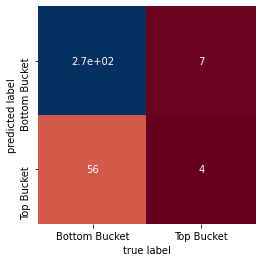

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(y_test, predictions)

sns.heatmap(cm, square=True, annot=True, cmap='RdBu', cbar=False,
xticklabels=['Bottom Bucket', 'Top Bucket'], yticklabels=['Bottom Bucket', 'Top Bucket'])
plt.xlabel('true label')
plt.ylabel('predicted label')

**Feature Importance**

To explore feature importance we first reviewed the top most important words first for each segment, but they returned similar results. To try to get a list of more unique words that still contributed strongly to the estimation, we updated the range to include the top 30 through 50 words. 

You can see from the keywords that those companies that were in the top 20% of companies used words such as software and cloud, whereas the other 80% had words such as retail, insurance. It would make sense that cloud and software companies are less affected by the COVID-19 pandemic because a lot of their services can be done remotely. It is retail and restaurants and real estate that would suffer more in this crisis. 

In [ ]:
def important_features(vectorizer,classifier):
    class_labels = classifier.classes_
    feature_names =vectorizer.get_feature_names()

    topn_class1 = sorted(zip(classifier.feature_count_[0], feature_names),reverse=True)[30:50]
    topn_class2 = sorted(zip(classifier.feature_count_[1], feature_names),reverse=True)[30:50]

    print("Important words in bottom 80%")

    for coef, feat in topn_class1:
        print(class_labels[0], coef, feat)

    print("-----------------------------------------")
    print("Important words in top 20%")

    for coef, feat in topn_class2:
        print(class_labels[1], coef, feat)

In [ ]:
# this is the vectorizer = cv cv.get_feature_names()
important_features(cv, naive_bayes)

Important words in bottom 80%
0 298.0 insurance
0 292.0 banking
0 284.0 customers
0 279.0 retail
0 277.0 business
0 276.0 consumer
0 270.0 segments
0 269.0 financial
0 268.0 new
0 247.0 development
0 246.0 real
0 246.0 industrial
0 224.0 investment
0 224.0 health
0 224.0 amp
0 222.0 gas
0 221.0 technology
0 216.0 home
0 214.0 mobile
0 214.0 estate
-----------------------------------------
Important words in top 20%
1 75.0 software
1 75.0 segments
1 74.0 markets
1 73.0 banking
1 72.0 retail
1 70.0 service
1 69.0 new
1 69.0 consumer
1 65.0 phase
1 65.0 applications
1 63.0 natural
1 60.0 equipment
1 58.0 primarily
1 57.0 cloud
1 57.0 accounts
1 56.0 insurance
1 56.0 care
1 56.0 amp
1 55.0 credit
1 54.0 network


# Conclusion


To conclude on our analysis, we found that we were able to get some predictive power from analyzing the descriptions of companies and the returns of those companies in the last 3 months. Being restricted to using 2 buckets meant that we could only look at companies in the top 20% and then the rest of the companies in the bottom 80%.
Had we had more time we also would have like to run some other models to determine if we were maximizing the accuracy of our analysis.

We are confident that there is a relationship between the descriptions of companies and the relative return in the last 3 months. It would seem companies in the software space and cloud-based companies were not as heavily affected as those that are in retail and the restaurant industry.

One limitation that we have with this data is the variation in industries, for example, restaurants are not typically traded on the stock exchange and therefore their data was not included. It would have been interesting to see how the COVID pandemic in the last 3 months typically affected the restaurant industry as a whole, and maybe other industries that are not heavily represented on our dataset.

It also would have been interesting to run a similar analysis using a different outcome variable, such as revenue. This would have given us a different outlook and most probably different results, which we then could have compared to the 3-month returns.

